In [47]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [50]:
from koopmanlib.functions import *

In [51]:
import json
import sys

# Generate data

In [52]:
config_file = "config_fhn.json"

In [53]:
with open(config_file, "r") as f:
    config = json.load(f)["fhn_settings"]

In [54]:
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]

In [55]:
Nx = config["data_settings"]["Nx"]
n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

In [56]:
n_psi_train = config["nn_settings"]["n_psi_train"]
target_dim = Nx * 2
param_dim = 1
n_psi = 1 + target_dim + n_psi_train
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

In [57]:
x = np.linspace(-10, 10, Nx)
t = np.arange(0, traj_len, 1)

In [58]:
from koopmanlib.target import FitzHughNagumoTarget

In [59]:
fhn_pde = FitzHughNagumoTarget(
    x=x, dt=1e-5, t_step=1e-3, dim=target_dim, param_dim=param_dim, param_input=1e3
)

In [60]:
data_dict = np.load(os.path.join(data_path, "data_fhn_Nx_" + str(Nx) + ".npy"), allow_pickle=True)

In [61]:
data_z_curr = data_dict[()]["data_z_curr"]
data_u = data_dict[()]["data_u"]
data_z_next = data_dict[()]["data_z_next"]

In [62]:
data_z_curr.shape

(49900, 20)

In [63]:
data_z_curr_reshape = data_z_curr.reshape(-1, n_traj, target_dim)
data_z_curr_reshape_trans = np.transpose(data_z_curr_reshape, (1, 0, 2))
sample_idx = 1

In [64]:
from sklearn.preprocessing import StandardScaler

scaler_z = StandardScaler()
scaler_z.fit(data_z_curr)

z_curr_normalized = scaler_z.transform(data_z_curr)
z_next_normalized = scaler_z.transform(data_z_next)

# After the prediction, we use inverse_transform to recover data.

# z_curr_recover = scaler_z.inverse_transform(z_curr_normalized)

# Build model

In [65]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [66]:
from tensorflow.keras.optimizers import Adam

In [67]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [68]:
from koopmanlib.K_structure import Model_K_u_Layer_One, Model_ResNet_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [69]:
model_pk.load_weights(
    os.path.join(
        weights_path, "norm_psi_" + str(n_psi_train) + "_model_pk_fhn_Nx_" + str(Nx) + ".h5"
    )
)

# Prediction

In [70]:
n_traj_test = 1
traj_len_test = 500

In [71]:
data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_pk,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=11,
    seed_param=11,
)

In [72]:
data_true_normalized.shape, data_pred_pk_normalized.shape, z_curr_ori.shape

((499, 20), (499, 20), (499, 20))

In [73]:
x_axis = x
y_axis = np.arange(0, data_true_normalized.shape[0], 1)

In [74]:
ratio_pk_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_pk_normalized)

In [75]:
data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)

In [76]:
ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)

In [77]:
data_pred_pk_normalized.shape

(499, 20)

# RBF + Ploynomial K (1, $u, u^2, u^3$)

In [78]:
from koopmanlib.dictionary import DicGaussianRBF

dic_rbf_fhn = DicGaussianRBF(rbf_number=n_psi_train, s=1 / 20)

dic_rbf_fhn.build(z_curr_normalized)

from koopmanlib.param_solver import KoopmanActuatedDLSolver

solver_rbf = KoopmanActuatedDLSolver(
    dic=dic_rbf_fhn,
    target_dim=target_dim,
    param_dim=param_dim,
    n_psi=n_psi,
    basis_u_func=fhn_pde.basis_u_func,
)

model_rbf = solver_rbf.build_model()

model_rbf_opt = solver_rbf.opt_rbf_model(
    data_x=z_curr_normalized, data_u=data_u, data_y=z_next_normalized
)

In [79]:
data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_rbf,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=11,
    seed_param=11,
)

In [80]:
ratio_rbf_normalized = compute_diff_ratio_one_traj(data_true_normalized, data_pred_rbf_normalized)

In [81]:
# Original space
data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)

In [82]:
data_pred_rbf_recover.shape

(499, 20)

In [83]:
ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)

# DL + Polynomial K (1, $u, u^2, u^3$)

In [84]:
dic_dl_polyK = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

solver_dl_polyK = KoopmanActuatedDLSolver(
    dic=dic_dl_polyK,
    target_dim=target_dim,
    param_dim=param_dim,
    n_psi=n_psi,
    basis_u_func=fhn_pde.basis_u_func,
)

model_dl_polyK = solver_dl_polyK.build_model()

In [85]:
solver_dl_polyK.model.load_weights(
    os.path.join(
        weights_path, "norm_psi_" + str(n_psi_train) + "_model_dl_polyK_fhn_Nx_" + str(Nx) + ".h5"
    )
)

In [86]:
data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(
    target=fhn_pde,
    scaler=scaler_z,
    solver=solver_dl_polyK,
    n_traj=n_traj_test,
    traj_len=traj_len_test,
    seed_z=11,
    seed_param=11,
)

In [87]:
ratio_dl_polyK_normalized = compute_diff_ratio_one_traj(
    data_true_normalized, data_pred_dl_polyK_normalized
)

In [88]:
# Original space
data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)

In [89]:
ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_polyK_recover)

# Average Prediction

In [90]:
np.random.seed(111)
n_test = 10
seed_z_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))

n_traj_test = 1

x_axis = x
y_axis = np.arange(0, traj_len_test - 1, 1)

In [91]:
ratio_pk_list = []
ratio_rbf_list = []
ratio_dl_polyK_list = []

for seed_z, seed_param in zip(seed_z_list, seed_param_list):

    data_true_normalized, data_pred_pk_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_pk,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_true_normalized, data_pred_rbf_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_rbf,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_true_normalized, data_pred_dl_polyK_normalized, z_curr_ori = recover_prediction(
        target=fhn_pde,
        scaler=scaler_z,
        solver=solver_dl_polyK,
        n_traj=n_traj_test,
        traj_len=traj_len_test,
        seed_z=seed_z,
        seed_param=seed_param,
    )

    data_pred_pk_recover = scaler_z.inverse_transform(data_pred_pk_normalized)
    data_pred_rbf_recover = scaler_z.inverse_transform(data_pred_rbf_normalized)
    data_pred_dl_polyK_recover = scaler_z.inverse_transform(data_pred_dl_polyK_normalized)

    ratio_pk_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_pk_recover)
    ratio_rbf_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_rbf_recover)
    ratio_dl_polyK_recover = compute_diff_ratio_one_traj(z_curr_ori, data_pred_dl_polyK_recover)

    ratio_pk_list.append(ratio_pk_recover)
    ratio_rbf_list.append(ratio_rbf_recover)
    ratio_dl_polyK_list.append(ratio_dl_polyK_recover)

ratio_pk_list = np.asarray(ratio_pk_list)
ratio_rbf_list = np.asarray(ratio_rbf_list)
ratio_dl_polyK_list = np.asarray(ratio_dl_polyK_list)


mean_pk, std_pk, mean_plus_pk, mean_minus_pk = compute_stat_info(ratio_pk_list)
mean_rbf, std_rbf, mean_plus_rbf, mean_minus_rbf = compute_stat_info(ratio_rbf_list)
mean_dl_polyK, std_dl_polyK, mean_plus_dl_polyK, mean_minus_dl_polyK = compute_stat_info(
    ratio_dl_polyK_list
)

Text(0, 0.5, 'Error')

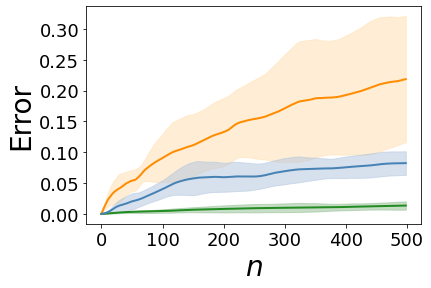

In [92]:
label_font = 16
ticks_font = 16
legend_font = 16
linewidth = 2

t_axis = np.arange(0, traj_len_test - 1, 1)

plt.plot(mean_rbf, label="M4-RBF", color="darkorange", linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_rbf, mean_plus_rbf, color="navajowhite", alpha=0.5)

plt.plot(mean_dl_polyK, label="M4-NN", color="forestgreen", linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_dl_polyK, mean_plus_dl_polyK, color="darkseagreen", alpha=0.5)

plt.plot(mean_pk, label="Ours", color="steelblue", linewidth=linewidth)
plt.fill_between(t_axis, mean_minus_pk, mean_plus_pk, color="lightsteelblue", alpha=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)

# plt.yscale('log')
# plt.legend(fontsize=14)
# plt.savefig(os.path.join(figures_path, 'fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


In [47]:
dict_error = {"pk": ratio_pk_list, "rbf": ratio_rbf_list, "dl": ratio_dl_polyK_list}

In [48]:
np.save(os.path.join(data_path, 'error_dict.npy'), dict_error)

In [49]:
data_pred_pk_recover.shape
# data_pred_rbf_recover
# data_pred_dl_polyK_recover 

(499, 20)

In [52]:
x_axis

array([-10.        ,  -7.77777778,  -5.55555556,  -3.33333333,
        -1.11111111,   1.11111111,   3.33333333,   5.55555556,
         7.77777778,  10.        ])

/home/guoyue/Learning-Parametric-Koopman-Decompositions/src/koopmanlib/functions.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


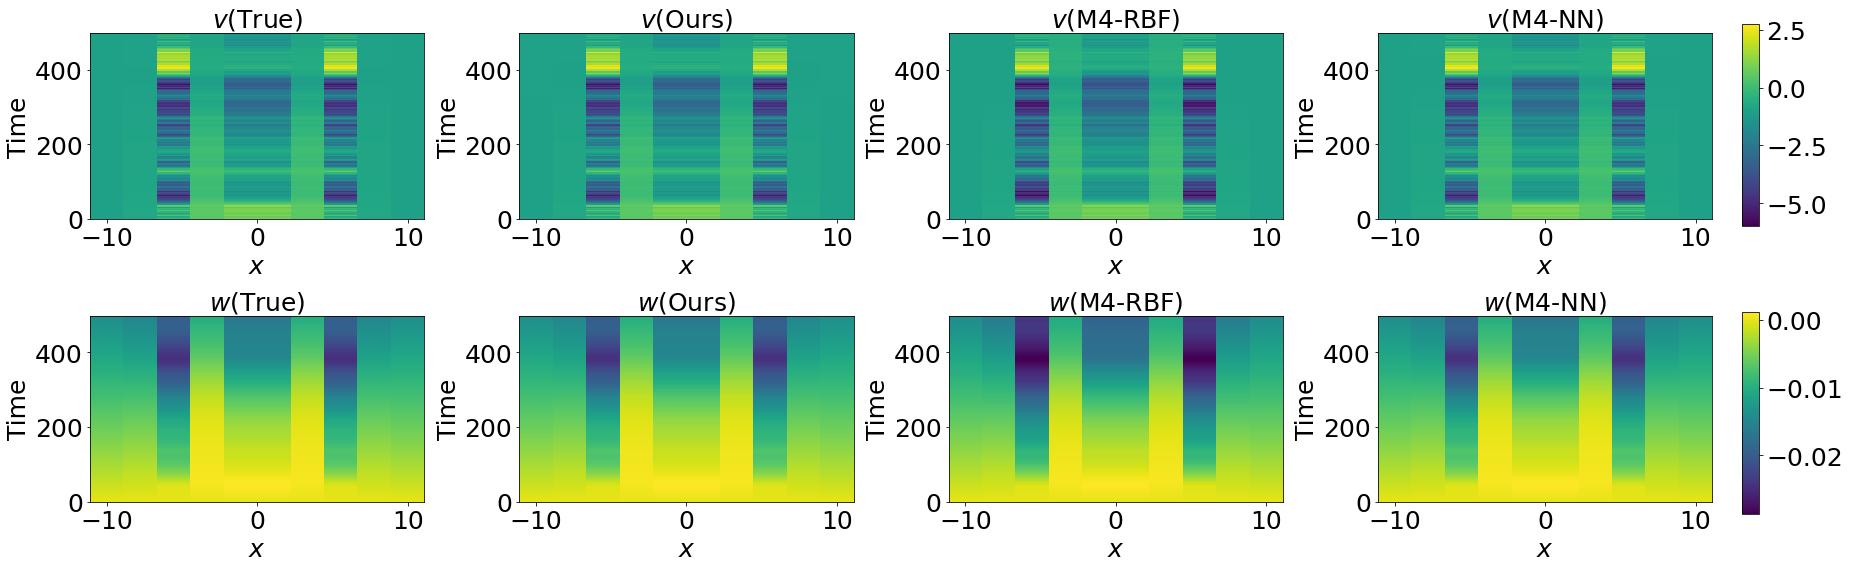

In [77]:
data_list = [z_curr_ori, data_pred_pk_recover, data_pred_rbf_recover, data_pred_dl_polyK_recover]
data_label_list = ['True', 'Ours','M4-RBF', 'M4-NN' ]
# with plt.rc_context({'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}):
plot_pde_comparison(x_axis,
                    y_axis,
                    data_list,
                    data_label_list, 
                    Nx, 
                    figsize=(24,8),
                    cbar_ax = ([1.01, 0.60, 0.01, 0.35], [1.01, 0.10, 0.01, 0.35]),
                    fontsize=25)

plt.savefig(os.path.join(figures_path, 'traj_fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'traj_fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


/home/guoyue/Learning-Parametric-Koopman-Decompositions/src/koopmanlib/functions.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


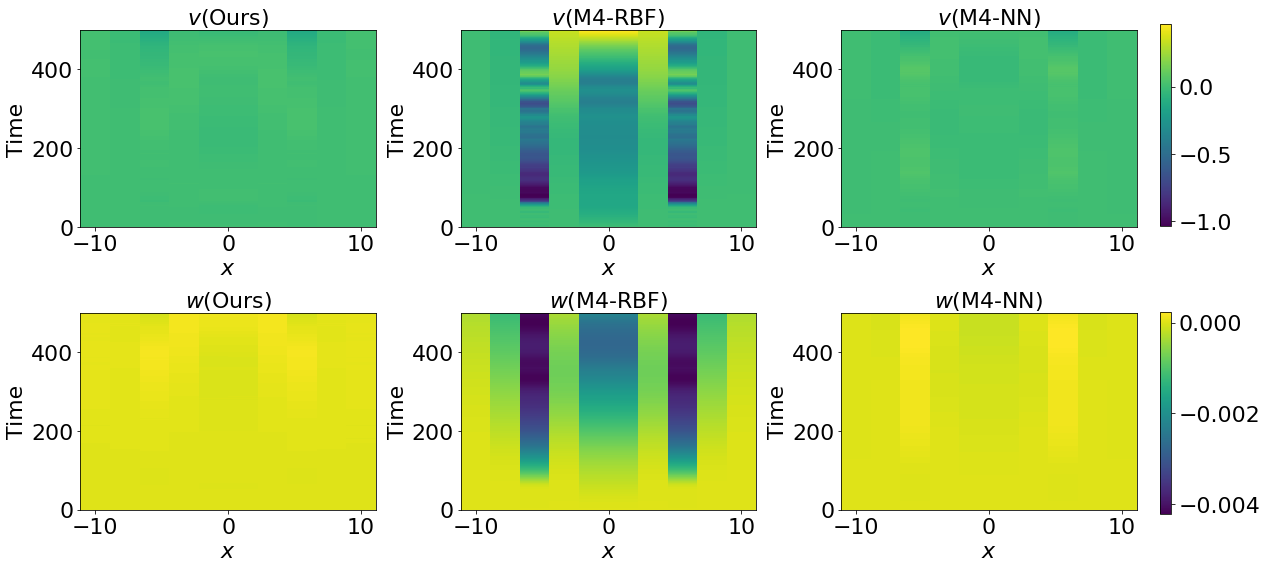

In [78]:
data_diff_list = [data_list[1]-data_list[0], data_list[2]-data_list[0], data_list[3]-data_list[0]]
data_diff_label_list = data_label_list[1:]

plot_pde_comparison(x_axis,
                    y_axis,
                    data_diff_list, 
                    data_diff_label_list, 
                    Nx,
                    figsize=(16,8),
                    cbar_ax = ([1.01, 0.60, 0.01, 0.35], [1.01, 0.10, 0.01, 0.35]),
                    fontsize=22)

plt.savefig(os.path.join(figures_path, 'diff_traj_fhn_error_Nx10.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'diff_traj_fhn_error_Nx10.pdf'), dpi=200, bbox_inches='tight')


# Test polynomial

In [127]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate Data
x = data_u  # 400 data points between -2 and 2
y = np.hstack([x, x**2, x**3])  # Corresponding [x, x^2, x^3] values


# Define the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(3)  # Output layer for [x, x^2, x^3]
])

# Compile the Model
model.compile(optimizer='adam', loss='mse')



In [128]:

# Train the Model
history = model.fit(x, y, epochs=100, verbose=1)


Epoch 1/100
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0605
Epoch 2/100
1560/1560 [==============================] - 2s 1ms/step - loss: 0.0053
Epoch 3/100
1560/1560 [==============================] - 2s 1ms/step - loss: 5.8009e-04
Epoch 4/100
1560/1560 [==============================] - 2s 1ms/step - loss: 1.5093e-04
Epoch 5/100
1560/1560 [==============================] - 2s 1ms/step - loss: 4.5567e-05
Epoch 6/100
1560/1560 [==============================] - 2s 1ms/step - loss: 2.5910e-05
Epoch 7/100
1560/1560 [==============================] - 2s 1ms/step - loss: 2.2362e-05
Epoch 8/100
1560/1560 [==============================] - 2s 1ms/step - loss: 2.0058e-05
Epoch 9/100
1560/1560 [==============================] - 2s 1ms/step - loss: 1.8723e-05
Epoch 10/100
1560/1560 [==============================] - 2s 1ms/step - loss: 1.7333e-05
Epoch 11/100
1560/1560 [==============================] - 2s 1ms/step - loss: 1.6318e-05
Epoch 12/100
1560/1560 [==============

In [94]:
# data_u_test = np.random.uniform(low=0, high=1, size=(n_traj, traj_len, param_dim))* (1+1) - 1
data_u_test = np.linspace(-1,1,100)
data_u_test = data_u_test.reshape(-1,1)

In [129]:


# Evaluate the Model
preds = model.predict(data_u_test)

y_test = np.hstack([data_u_test, data_u_test**2, data_u_test**3])


4/4 [==============================] - 0s 2ms/step


In [132]:

# Define the Neural Network
model_64 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(3)  # Output layer for [x, x^2, x^3]
])

# Compile the Model
model_64.compile(optimizer='adam', loss='mse')

# Train the Model
history_64 = model_64.fit(x, y, epochs=100, verbose=1)



Epoch 1/100
1560/1560 [==============================] - 3s 2ms/step - loss: 0.0200
Epoch 2/100
1560/1560 [==============================] - 3s 2ms/step - loss: 5.9556e-04
Epoch 3/100
1560/1560 [==============================] - 3s 2ms/step - loss: 1.6240e-04
Epoch 4/100
1560/1560 [==============================] - 3s 2ms/step - loss: 1.0722e-04
Epoch 5/100
1560/1560 [==============================] - 3s 2ms/step - loss: 7.5987e-05
Epoch 6/100
1560/1560 [==============================] - 3s 2ms/step - loss: 5.3929e-05
Epoch 7/100
1560/1560 [==============================] - 3s 2ms/step - loss: 4.1645e-05
Epoch 8/100
1560/1560 [==============================] - 3s 2ms/step - loss: 3.4934e-05
Epoch 9/100
1560/1560 [==============================] - 3s 2ms/step - loss: 3.0125e-05
Epoch 10/100
1560/1560 [==============================] - 3s 2ms/step - loss: 2.9394e-05
Epoch 11/100
1560/1560 [==============================] - 3s 2ms/step - loss: 2.3081e-05
Epoch 12/100
1560/1560 [==========

In [133]:
# Evaluate the Model
preds_64 = model_64.predict(data_u_test)

4/4 [==============================] - 0s 1ms/step


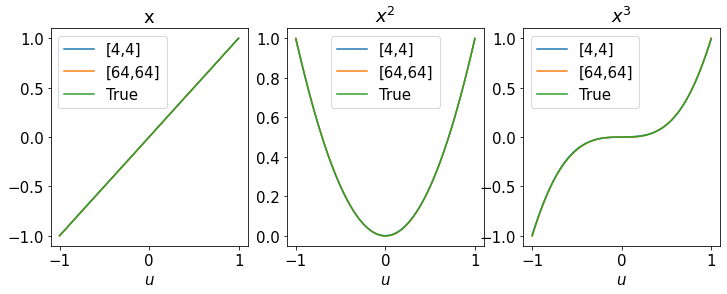

In [134]:
with matplotlib.rc_context({'font.size': 15}):

    # Plotting the results
    plt.figure(figsize=(12, 4))
    for i, title in enumerate(['x', '$x^2$', '$x^3$']):
        plt.subplot(1, 3, i + 1)
        plt.plot(data_u_test, preds[:, i], label="[4,4]")
        plt.plot(data_u_test, preds_64[:, i], label='[64,64]')
        plt.plot(data_u_test, y_test[:, i], label='True')
        plt.xlabel('$u$')
        plt.title(title)
        plt.legend()
    plt.show()



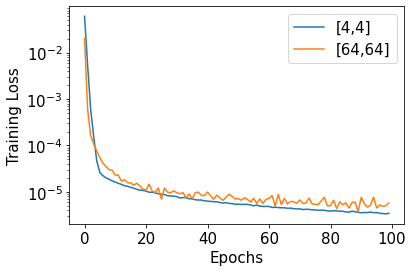

In [135]:
with matplotlib.rc_context({'font.size': 15}):
    plt.plot(history.history['loss'], label="[4,4]")
    plt.plot(history_64.history['loss'], label="[64,64]")
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.yscale('log')

    plt.legend()